In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(train_data, _), (test_data, _) =  tf.keras.datasets.mnist.load_data()
train_data = train_data/np.float32(255)
train_data = np.reshape(train_data, (train_data.shape[0], 784))


test_data = test_data/np.float32(255)
test_data = np.reshape(test_data, (test_data.shape[0], 784))

In [3]:
#Class that defines the behavior of the RBM
class RBM(object):
    
    def __init__(self, input_size, output_size, lr=1.0, batchsize=100):
        """
        m: Number of neurons in visible layer
        n: number of neurons in hidden layer
        """
        #Defining the hyperparameters
        self._input_size = input_size #Size of Visible
        self._output_size = output_size #Size of outp
        self.learning_rate = lr #The step used in gradient descent
        self.batchsize = batchsize #The size of how much data will be used for training per sub iteration
        
        #Initializing weights and biases as matrices full of zeroes
        self.w = tf.zeros([input_size, output_size], np.float32) #Creates and initializes the weights with 0
        self.hb = tf.zeros([output_size], np.float32) #Creates and initializes the hidden biases with 0
        self.vb = tf.zeros([input_size], np.float32) #Creates and initializes the visible biases with 0


    #Forward Pass
    def prob_h_given_v(self, visible, w, hb):
        #Sigmoid 
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    #Backward Pass
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    #Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    #Training method for the model
    def train(self, X, epochs=10):
               
        loss = []
        for epoch in range(epochs):
            #For each step/batch
            for start, end in zip(range(0, len(X), self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                batch = X[start:end]
                    
                #Initialize with sample probabilities
                    
                h0 = self.sample_prob(self.prob_h_given_v(batch, self.w, self.hb))
                v1 = self.sample_prob(self.prob_v_given_h(h0, self.w, self.vb))
                h1 = self.prob_h_given_v(v1, self.w, self.hb)
                    
                #Create the Gradients
                positive_grad = tf.matmul(tf.transpose(batch), h0)
                negative_grad = tf.matmul(tf.transpose(v1), h1)
                    
                #Update learning rates 
                self.w = self.w + self.learning_rate *(positive_grad - negative_grad) / tf.dtypes.cast(tf.shape(batch)[0],tf.float32)
                self.vb = self.vb +  self.learning_rate * tf.reduce_mean(batch - v1, 0)
                self.hb = self.hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
                    
            #Find the error rate
            err = tf.reduce_mean(tf.square(batch - v1))
            print ('Epoch: %d' % epoch,'reconstruction error: %f' % err)
            loss.append(err)
                    
        return loss
        
    #Create expected output for our DBN
    def rbm_output(self, X):
        out = tf.nn.sigmoid(tf.matmul(X, self.w) + self.hb)
        return out
    
    def rbm_reconstruct(self,X):
        h = tf.nn.sigmoid(tf.matmul(X, self.w) + self.hb)
        reconstruct = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.w)) + self.vb)
        return reconstruct
            

In [4]:
RESHAPED = 784
NB_CLASSES = 10   # number of outputs = number of digits

(train_data, Y_train), (test_data, Y_test) =  tf.keras.datasets.mnist.load_data()
train_data = train_data/np.float32(255)
train_data = np.reshape(train_data, (train_data.shape[0], RESHAPED))
Y_train = tf.keras.utils.to_categorical(Y_train, NB_CLASSES)
Y_test = tf.keras.utils.to_categorical(Y_test, NB_CLASSES)

test_data = test_data/np.float32(255)
test_data = np.reshape(test_data, (test_data.shape[0], RESHAPED))

In [5]:
RBM_hidden_sizes = [500, 200 , 50 ] #create 2 layers of RBM with size 400 and 100

#Since we are training, set input as training data
inpX = train_data

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = train_data.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print ('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size


RBM:  0   784 -> 500
RBM:  1   500 -> 200
RBM:  2   200 -> 50


In [6]:
#For each RBM in our list
for rbm in rbm_list:
    print ('Next RBM:')
    #Train a new one
    rbm.train(tf.cast(inpX,tf.float32)) 
    #Return the output layer
    inpX = rbm.rbm_output(inpX)

Next RBM:
Epoch: 0 reconstruction error: 0.056434
Epoch: 1 reconstruction error: 0.049873
Epoch: 2 reconstruction error: 0.048256
Epoch: 3 reconstruction error: 0.046911
Epoch: 4 reconstruction error: 0.045232
Epoch: 5 reconstruction error: 0.043050
Epoch: 6 reconstruction error: 0.044899
Epoch: 7 reconstruction error: 0.043522
Epoch: 8 reconstruction error: 0.043156
Epoch: 9 reconstruction error: 0.041891
Next RBM:
Epoch: 0 reconstruction error: 0.029479
Epoch: 1 reconstruction error: 0.025730
Epoch: 2 reconstruction error: 0.023860
Epoch: 3 reconstruction error: 0.022723
Epoch: 4 reconstruction error: 0.022520
Epoch: 5 reconstruction error: 0.022282
Epoch: 6 reconstruction error: 0.021761
Epoch: 7 reconstruction error: 0.021179
Epoch: 8 reconstruction error: 0.020641
Epoch: 9 reconstruction error: 0.020910
Next RBM:
Epoch: 0 reconstruction error: 0.051618
Epoch: 1 reconstruction error: 0.047273
Epoch: 2 reconstruction error: 0.047277
Epoch: 3 reconstruction error: 0.046827
Epoch: 4 r

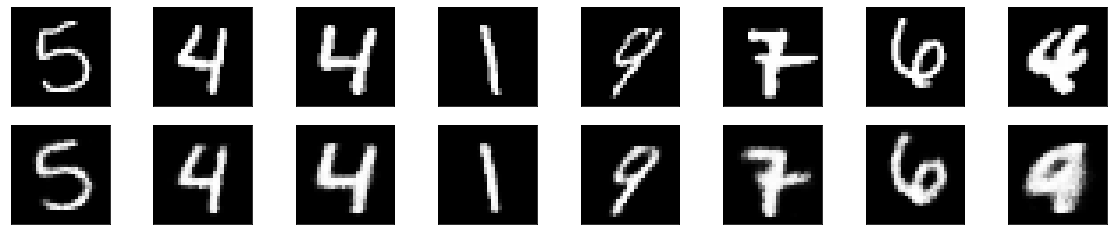

In [8]:
out = rbm_list[0].rbm_reconstruct(test_data)
# Plotting original and reconstructed images
row, col = 2, 8
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col, sharex=True, sharey=True, figsize=(20,4))
for fig, row in zip([test_data,out], axarr):
    for i,ax in zip(idx,row):
        ax.imshow(tf.reshape(fig[i],[28, 28]), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
